- Labels in this dataset:
    - 0: fish
    - 1: jellyfish
    - 2: penguin
    - 3: puffin
    - 4: shark
    - 5: starfish
    - 6: stingray


- More info:
    - Number of classes: 7
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-46dcb166-4a8f-1ecc-c47c-27ec620814be)
GPU 1: Tesla T4 (UUID: GPU-9f4b5dc8-3aaf-0ac6-9730-1aaaba1a823b)


# Installs/Imports

In [2]:
%%time

! pip install --upgrade ultralytics -qq


CPU times: user 172 ms, sys: 48.1 ms, total: 220 ms
Wall time: 14.2 s


In [3]:
import ultralytics
print(ultralytics.__version__)

8.1.37


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import torch

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [4]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [5]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 1

    # classes
    NUM_CLASSES = 7
    CLASSES = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

    # training
    EPOCHS = 100 
    BATCH_SIZE = 32
    
    BASE_MODEL = 'yolov8n' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 0.001
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/'
    OUTPUT_DIR = '/kaggle/working/'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [7]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [8]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- fish
- jellyfish
- penguin
- puffin
- shark
- starfish
- stingray
nc: 7
test: /kaggle/input/aquarium-data-cots/aquarium_pretrain/test
train: /kaggle/input/aquarium-data-cots/aquarium_pretrain/train
val: /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 768, 3) 



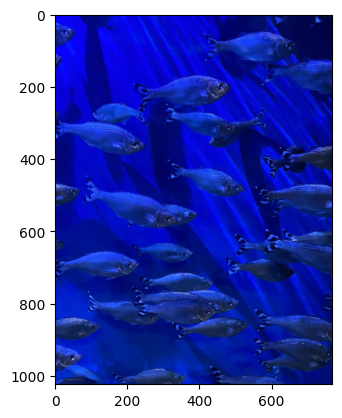

In [9]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()
    
example_image_path = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images/IMG_2274_jpeg_jpg.rf.2f319e949748145fb22dcb52bb325a0c.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

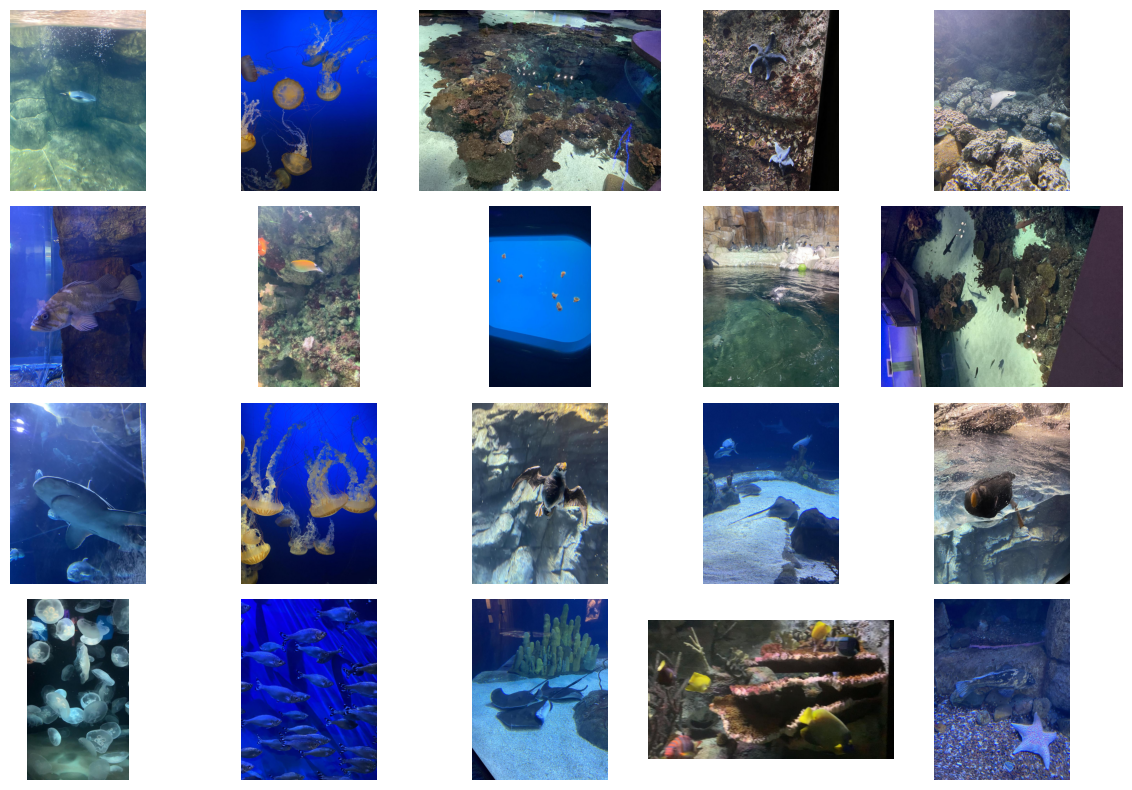

In [10]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()
    
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

## Image properties

In [11]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 768, 'height': 1024, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [15]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 53 ms, sys: 41 ms, total: 94 ms
Wall time: 4.38 s


Mode  fish  jellyfish  penguin  puffin  shark  starfish  stingray  \
0  train   240         32       47      45    134        37        91   
1  valid    63          9       17      15     28        17        23   
2   test    30         11        7       6     14         5        10   

   Data_Volume  
0          448  
1          127  
2           63

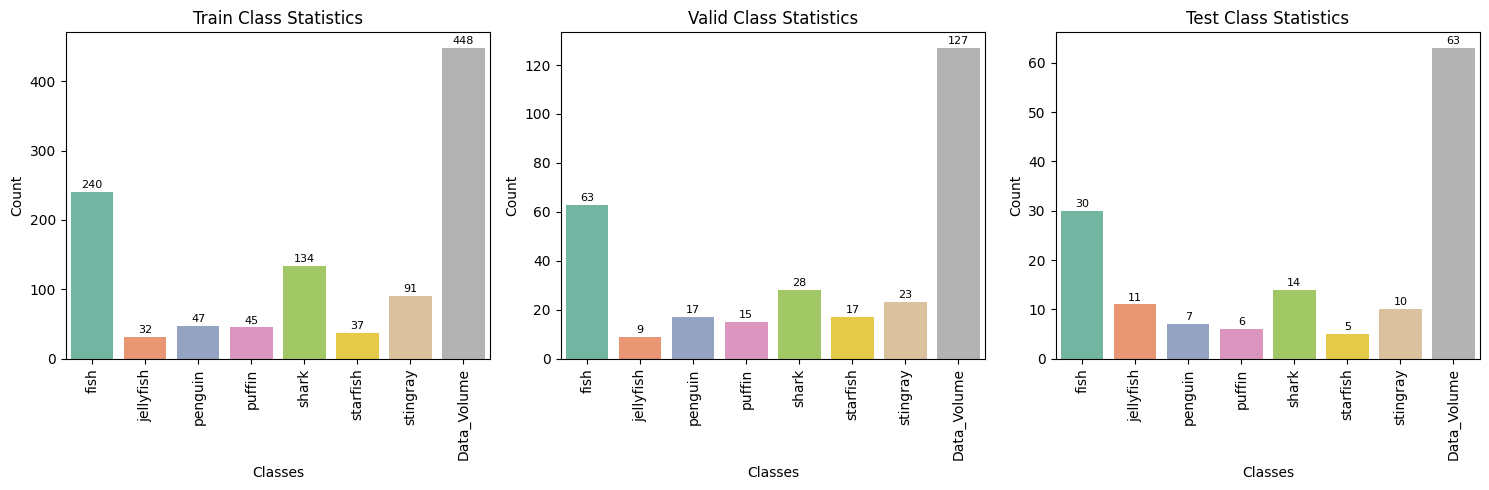

In [16]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [ ]:
# %%time

# for mode in ['train', 'valid', 'test']:
#     print(f'\nImage sizes in {mode} set:')

#     img_size = 0
#     for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

#         image = Image.open(file)

#         if image.size != img_size:
#             print(f'{image.size}')
#             img_size = image.size
#             print('\n')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [17]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8n.pt
Epochs:  100
Batch:  32


In [7]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
!pip install -U ipywidgets

In [ ]:
# import torch
# torch.cuda.empty_cache()
# cuda_available = torch.cuda.is_available()
# print(cuda_available)

In [ ]:
%%time

### train
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    imgsz = (img_properties['height'], img_properties['width']),
    seed = CFG.SEED,
    device = [0,1], #[0,1], # 0
    workers=4,
    name='yolov8n_underwater')

# Export

In [ ]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_underwater/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Evaluation

In [ ]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov8n_underwater/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

In [ ]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

# Test model


In [ ]:
results = model.predict(source=os.path.join(CFG.CUSTOM_DATASET_DIR, 'test', 'images'), save=True)
%matplotlib inline

predicitions = glob.glob(os.path.join(CFG.OUTPUT_DIR, 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

# Retrain model use augmention data

In [6]:
path = '/kaggle/input/underwater-augmention/aquarium_pretrain_augmention'
dict_file = {
    'train': os.path.join(path, 'train'),
    'val': os.path.join(path, 'valid'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [7]:
### read yaml file created

def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- fish
- jellyfish
- penguin
- puffin
- shark
- starfish
- stingray
nc: 7
train: /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train
val: /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/valid



In [21]:
!rm -rf /kaggle/working/runs/detect/yolov8n_underwater_augumention24

In [27]:
#retrain use model best.pt
model = YOLO('/kaggle/working/runs/detect/yolov8n_underwater_augumention5/weights/best.pt')

results_aug = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml'),
    degrees=0.5, #aug
    scale=0.5, #aug
    perspective=0.0001,#aug 
    epochs = 100,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    imgsz = (1024, 768),
    seed = CFG.SEED,
    device = [0,1], #[0,1], # 0
    workers=4,
    name='yolov8n_underwater_augumention')

Ultralytics YOLOv8.1.37 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/yolov8n_underwater_augumention5/weights/best.pt, data=/kaggle/working/data_aug.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=[0, 1], workers=4, project=None, name=yolov8n_underwater_augumention6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnos

2024-03-29 19:14:49.813067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 19:14:49.813118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 19:14:49.814734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov8n_underwater_augumention6', view at http://localhost:6006/
Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train/labels... 894 images, 447 backgrounds, 0 corrupt: 100%|██████████| 1341/1341 [00:01<00:00, 958.03it/s] 


train: WARNING ⚠️ Cache directory /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/valid/labels... 381 images, 0 backgrounds, 0 corrupt: 100%|██████████| 381/381 [00:00<00:00, 486.09it/s]it/s]
train: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train/labels... 447 images, 386 backgrounds, 0 corrupt:  62%|██████▏   | 833/1341 [00:00<00:00, 1124.41it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/valid is not writeable, cache not saved.


train: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train/labels... 894 images, 447 backgrounds, 0 corrupt: 100%|██████████| 1341/1341 [00:01<00:00, 842.85it/s]


Plotting labels to runs/detect/yolov8n_underwater_augumention6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_underwater_augumention6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.44G      1.001     0.9229      1.146         25       1024: 100%|██████████| 42/42 [00:44<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


                   all        381       2721      0.727      0.579      0.609      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.97G     0.9526     0.8902      1.091        100       1024: 100%|██████████| 42/42 [00:40<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


                   all        381       2721      0.664      0.559       0.58      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.99G     0.9619     0.8962      1.073        146       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


                   all        381       2721      0.629      0.498      0.504      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.32G     0.9922     0.8966      1.084        206       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


                   all        381       2721      0.629      0.582      0.564      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.96G      1.022     0.8888       1.09         68       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


                   all        381       2721       0.64      0.548      0.548      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.71G     0.9813     0.8821      1.076        120       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


                   all        381       2721      0.644      0.578      0.565      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.23G     0.9971     0.8631      1.069        117       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


                   all        381       2721      0.605      0.555      0.537      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.43G      1.023     0.8805      1.094        112       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


                   all        381       2721      0.646      0.556      0.571      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       5.8G      1.001      0.877      1.069         78       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.688      0.521      0.551      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.13G      1.006      0.901      1.078        100       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


                   all        381       2721      0.669      0.604      0.605       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.45G     0.9967     0.8564      1.067        115       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.678      0.554      0.582      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.61G     0.9722     0.8534       1.07        151       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.633      0.584      0.562      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.42G     0.9874     0.8707      1.066         83       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


                   all        381       2721      0.609      0.564      0.543      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.17G     0.9525     0.8156      1.057         99       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


                   all        381       2721       0.62      0.558      0.561      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.28G     0.9995     0.8504      1.084         96       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


                   all        381       2721      0.665      0.537      0.553      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.72G     0.9751     0.8352      1.072        143       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.674      0.553      0.569      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.36G     0.9398     0.8332      1.058        146       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


                   all        381       2721       0.62      0.618      0.586        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.62G     0.9481     0.7916      1.045        145       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


                   all        381       2721      0.604      0.499        0.5      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.87G     0.9516     0.7812      1.047        108       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


                   all        381       2721      0.642      0.531      0.547      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.66G     0.9124     0.8429       1.05        137       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


                   all        381       2721      0.687      0.604      0.614      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.18G     0.9607     0.7862      1.046         62       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


                   all        381       2721      0.666       0.58      0.583        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.69G     0.9653     0.8102      1.061         67       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


                   all        381       2721      0.658      0.592      0.584      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.01G     0.9359     0.8032      1.037        209       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


                   all        381       2721      0.644      0.599      0.592      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       6.8G     0.9732     0.8007      1.063        217       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


                   all        381       2721      0.682      0.555      0.573      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.77G     0.9499     0.8176      1.048        148       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


                   all        381       2721      0.668      0.603      0.592      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.03G     0.9236      0.827       1.05         27       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


                   all        381       2721      0.651      0.569      0.562      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.64G     0.9682      0.834      1.075        134       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


                   all        381       2721      0.661      0.588      0.593        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.56G     0.9338     0.8023      1.053         80       1024: 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


                   all        381       2721      0.646      0.618      0.611      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.24G     0.8947     0.8028      1.031         86       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


                   all        381       2721      0.694      0.579      0.598      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.04G     0.9062     0.7416      1.024        140       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


                   all        381       2721      0.658      0.609      0.619      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.27G     0.9281     0.7883      1.031        148       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


                   all        381       2721      0.642      0.596        0.6      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.25G     0.9109     0.7867      1.023        157       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


                   all        381       2721      0.669      0.613       0.61      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.24G     0.9153      0.769      1.037        219       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


                   all        381       2721      0.671      0.639      0.633       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.21G     0.9381     0.7942      1.055         85       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


                   all        381       2721      0.657      0.621      0.608      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.59G     0.8961     0.7372      1.018        112       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


                   all        381       2721       0.65      0.601      0.586      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.89G     0.9132     0.8076      1.042        223       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.658       0.59      0.594      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.14G     0.9148     0.7614       1.04         85       1024: 100%|██████████| 42/42 [00:39<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


                   all        381       2721       0.68      0.612      0.626      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.03G     0.8962     0.7702      1.037         56       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


                   all        381       2721      0.698      0.615      0.643      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.22G     0.8614      0.716      1.007         73       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


                   all        381       2721       0.67       0.61      0.605      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.65G     0.8994     0.7652      1.028        123       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


                   all        381       2721      0.663      0.608      0.608      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.96G     0.9063     0.7387      1.034        172       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


                   all        381       2721      0.671      0.611      0.606      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.81G     0.8901     0.7653      1.031        124       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]


                   all        381       2721      0.669      0.577      0.588      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.59G     0.9062     0.7742      1.035         77       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


                   all        381       2721       0.69      0.608      0.628      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.48G     0.8843     0.7409      1.017        100       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.708      0.589      0.617      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.34G     0.8589     0.7406      1.016        139       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


                   all        381       2721      0.708      0.595      0.636      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.72G     0.8516      0.738      1.002        165       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.668      0.585      0.611       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.43G     0.8862     0.7651      1.021         66       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


                   all        381       2721      0.691      0.622       0.64      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.05G     0.8768     0.7093      1.014        125       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


                   all        381       2721       0.68      0.608      0.615      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.09G     0.8613     0.7217      1.027        169       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


                   all        381       2721      0.675      0.607      0.614      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.52G     0.8857     0.7688      1.032        139       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


                   all        381       2721      0.653      0.601      0.599      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.16G     0.8663     0.6864      1.015        120       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


                   all        381       2721      0.647      0.603      0.608      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.13G       0.86      0.722      1.013        138       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


                   all        381       2721      0.661      0.565      0.595      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.38G     0.8335      0.661     0.9995        140       1024: 100%|██████████| 42/42 [00:40<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


                   all        381       2721      0.672      0.605      0.614       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.38G     0.8632     0.7162      1.017         99       1024: 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


                   all        381       2721      0.638      0.586       0.59      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.09G     0.8617     0.7277      1.012        145       1024: 100%|██████████| 42/42 [00:40<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]


                   all        381       2721      0.694      0.596      0.629      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.32G     0.8426     0.6911          1        117       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


                   all        381       2721      0.662      0.604      0.601      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.39G     0.8594     0.7391      1.008        112       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


                   all        381       2721      0.686      0.583      0.612      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.68G     0.8133     0.6776     0.9869         75       1024: 100%|██████████| 42/42 [00:40<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


                   all        381       2721      0.676      0.605      0.613       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.05G     0.8259     0.7017     0.9929        179       1024: 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


                   all        381       2721      0.676      0.575      0.595      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.96G     0.8355     0.6913     0.9937        109       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


                   all        381       2721      0.697      0.579       0.61      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.37G     0.8221     0.6916     0.9913        121       1024: 100%|██████████| 42/42 [00:40<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


                   all        381       2721      0.679      0.596      0.613      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.44G     0.8244     0.6668     0.9956         55       1024: 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


                   all        381       2721      0.669        0.6      0.609      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       6.7G     0.8114      0.667     0.9937         75       1024: 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


                   all        381       2721      0.678      0.594      0.611      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.58G     0.7772      0.648     0.9938        197       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.668      0.627      0.621      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.91G     0.8051     0.6564     0.9871         94       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721      0.665      0.598      0.614      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.59G      0.809     0.6975      1.001        199       1024: 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


                   all        381       2721      0.666      0.606      0.624      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.07G     0.8004     0.6544     0.9844         72       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


                   all        381       2721      0.656      0.596      0.603      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.56G     0.8023     0.6728     0.9875         88       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


                   all        381       2721      0.672      0.572      0.604      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.37G     0.8015      0.653      0.982        100       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


                   all        381       2721      0.643       0.62      0.612      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.29G     0.8407     0.6817     0.9998         73       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


                   all        381       2721      0.657      0.605      0.613      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.47G     0.7929     0.6494      0.972        152       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


                   all        381       2721      0.655       0.61      0.616       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.22G      0.793     0.6349     0.9881        104       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


                   all        381       2721      0.685      0.601       0.62      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.61G     0.7885     0.6534     0.9805        100       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


                   all        381       2721      0.669      0.616      0.626      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.45G     0.8081     0.6605     0.9951        155       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


                   all        381       2721        0.7      0.576      0.623      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.82G     0.8091     0.6851      0.992         58       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


                   all        381       2721      0.656      0.599      0.614      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.38G      0.775     0.6945     0.9884         83       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


                   all        381       2721      0.666      0.596      0.617      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.92G     0.8028     0.6501     0.9971         61       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


                   all        381       2721      0.671      0.575      0.612       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         7G     0.7889     0.6638     0.9836        126       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


                   all        381       2721      0.656      0.593      0.608      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.51G     0.7572     0.6179     0.9717        128       1024: 100%|██████████| 42/42 [00:38<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


                   all        381       2721      0.648      0.627      0.618      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.53G      0.757     0.5945     0.9618        123       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


                   all        381       2721       0.67      0.586      0.614      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.92G     0.7638     0.6206     0.9719         88       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


                   all        381       2721      0.675      0.583      0.607      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.42G     0.7621     0.5953     0.9677        108       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


                   all        381       2721      0.668      0.621      0.626      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.69G     0.7659     0.6443     0.9756        120       1024: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


                   all        381       2721      0.649      0.596      0.606      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.87G      0.753     0.6063     0.9733        149       1024: 100%|██████████| 42/42 [00:40<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


                   all        381       2721      0.669        0.6      0.623      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.05G      0.752     0.6242     0.9696        150       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


                   all        381       2721      0.681      0.617      0.628      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.85G     0.7854     0.6197     0.9808        141       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


                   all        381       2721       0.67      0.595      0.622      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.06G     0.7498     0.6038     0.9557        114       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


                   all        381       2721      0.665      0.604      0.617      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.42G     0.7509      0.638     0.9683         66       1024: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


                   all        381       2721      0.671      0.616      0.624      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.62G     0.7639     0.6182     0.9565        130       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


                   all        381       2721       0.67      0.596      0.615      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.51G     0.7296     0.5905      0.951        103       1024: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


                   all        381       2721      0.673      0.574      0.611      0.332
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.54G     0.7406      0.604     0.9652         79       1024: 100%|██████████| 42/42 [00:40<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


                   all        381       2721      0.663       0.59      0.611      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.34G     0.6934     0.5449     0.9366         79       1024: 100%|██████████| 42/42 [00:37<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


                   all        381       2721      0.668        0.6      0.615      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.05G     0.6743     0.5324     0.9249         33       1024: 100%|██████████| 42/42 [00:37<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


                   all        381       2721      0.663      0.624      0.629       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.02G     0.6931     0.5608     0.9357         76       1024: 100%|██████████| 42/42 [00:37<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


                   all        381       2721      0.671      0.604      0.622      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.08G     0.6973     0.5638     0.9325         70       1024: 100%|██████████| 42/42 [00:37<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


                   all        381       2721      0.658      0.597       0.62      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.66G     0.6855      0.551     0.9351         70       1024: 100%|██████████| 42/42 [00:37<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


                   all        381       2721       0.66      0.598       0.62      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       5.7G     0.6658      0.555     0.9207         33       1024: 100%|██████████| 42/42 [00:37<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


                   all        381       2721      0.672      0.604      0.633      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.04G     0.6749     0.5651     0.9255         39       1024: 100%|██████████| 42/42 [00:37<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


                   all        381       2721      0.676        0.6      0.635      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.74G      0.663     0.5407     0.9334         96       1024: 100%|██████████| 42/42 [00:37<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


                   all        381       2721      0.666      0.593      0.626      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       6.1G     0.6534     0.5255     0.9152         44       1024: 100%|██████████| 42/42 [00:37<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


                   all        381       2721      0.667      0.603      0.627      0.343

100 epochs completed in 1.253 hours.
Optimizer stripped from runs/detect/yolov8n_underwater_augumention6/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_underwater_augumention6/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_underwater_augumention6/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


                   all        381       2721      0.674      0.606      0.635      0.346
                  fish        381       1376      0.714      0.628      0.684      0.373
             jellyfish        381        462      0.804      0.799      0.833       0.45
               penguin        381        310      0.519      0.648      0.586      0.252
                puffin        381        222      0.545      0.378      0.388      0.197
                 shark        381        171      0.634      0.515      0.546      0.302
              starfish        381         81      0.782      0.605      0.699      0.407
              stingray        381         99      0.717      0.667      0.706      0.439
Speed: 0.6ms preprocess, 5.6ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to runs/detect/yolov8n_underwater_augumention6


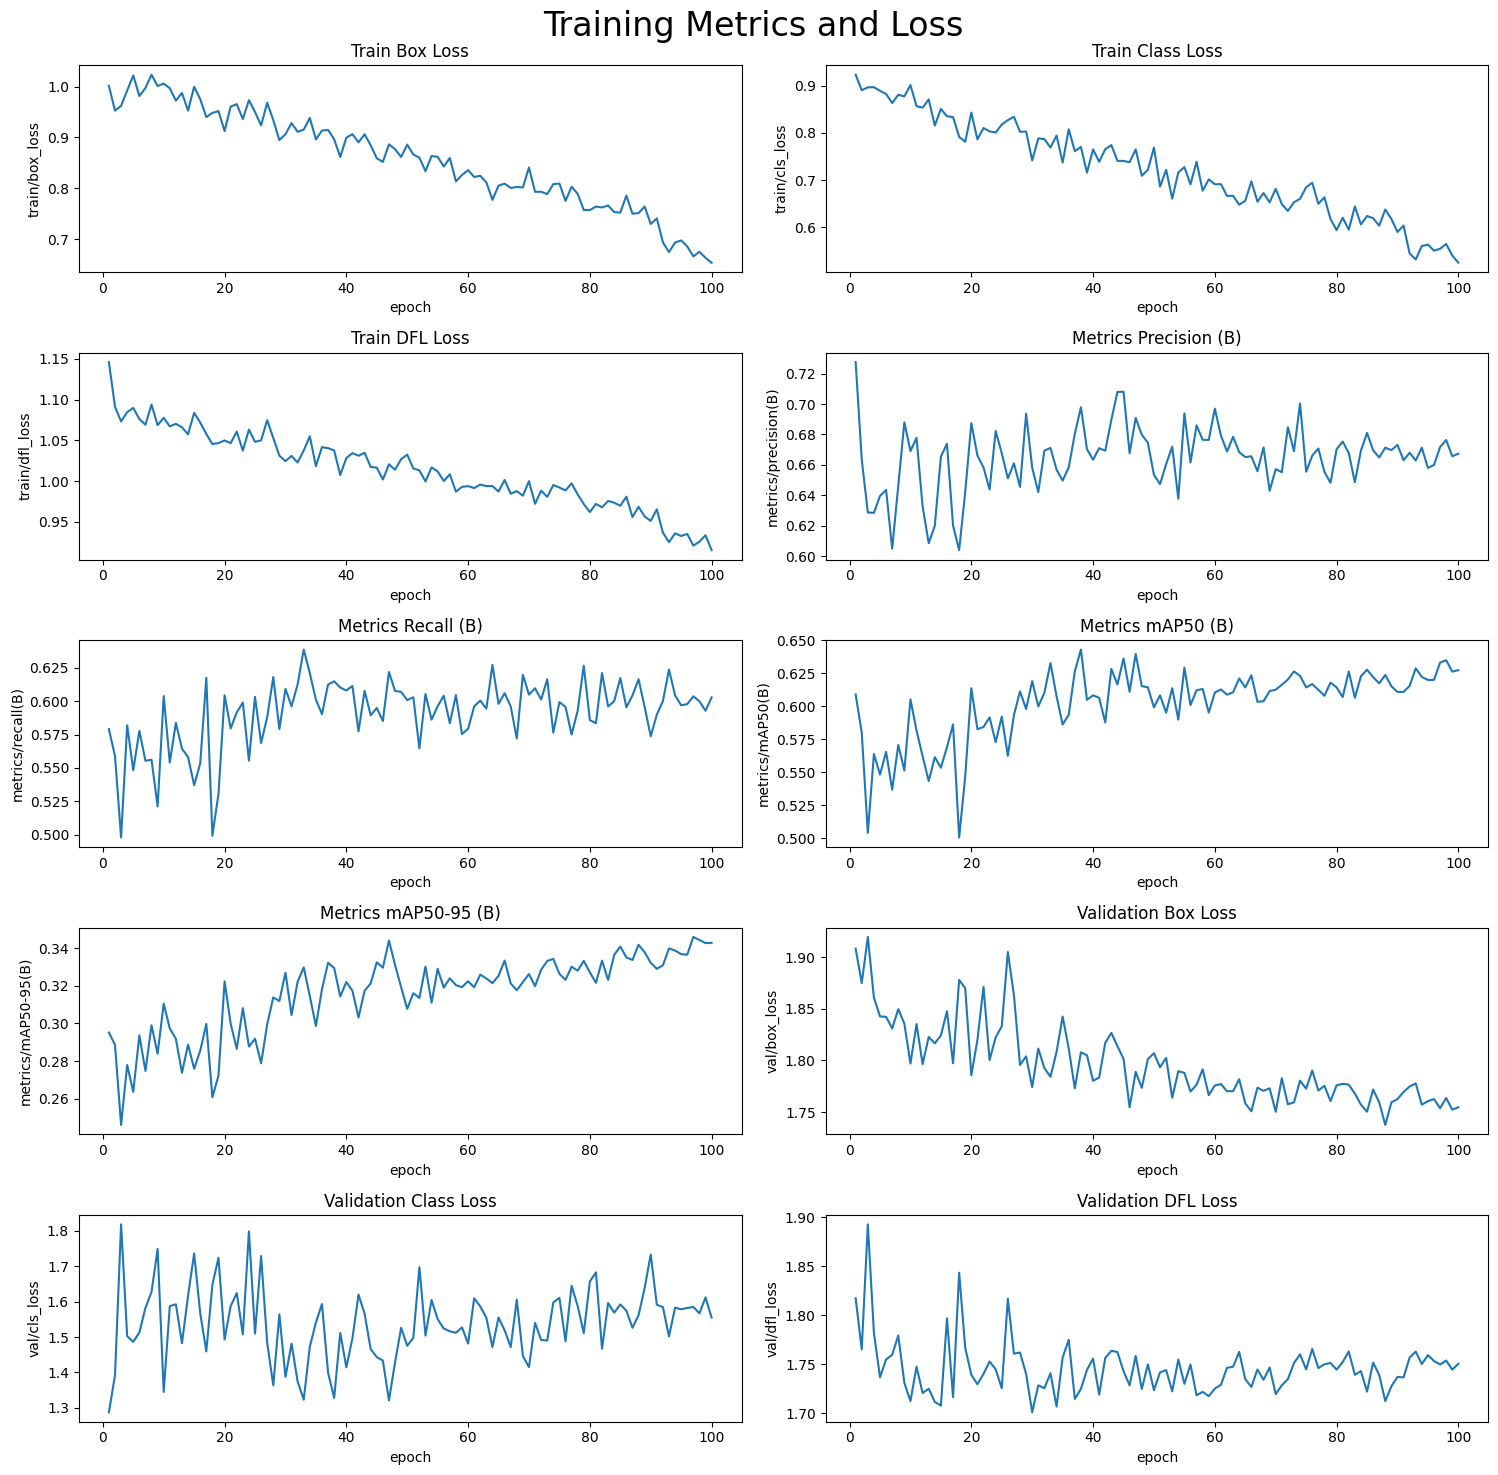

[E ProcessGroupNCCL.cpp:475] [Rank 1] Watchdog caught collective operation timeout: WorkNCCL(SeqNum=7, OpType=BROADCAST, NumelIn=10400, NumelOut=10400, Timeout(ms)=10800000) ran for 10800008 milliseconds before timing out.
[E ProcessGroupNCCL.cpp:541] [Rank 1] Work WorkNCCL(SeqNum=7, OpType=BROADCAST, NumelIn=10400, NumelOut=10400, Timeout(ms)=10800000) timed out in blocking wait (NCCL_BLOCKING_WAIT=1).
[E ProcessGroupNCCL.cpp:489] Some NCCL operations have failed or timed out. Due to the asynchronous nature of CUDA kernels, subsequent GPU operations might run on corrupted/incomplete data.
[E ProcessGroupNCCL.cpp:495] To avoid data inconsistency, we are taking the entire process down.
[E ProcessGroupNCCL.cpp:489] Some NCCL operations have failed or timed out. Due to the asynchronous nature of CUDA kernels, subsequent GPU operations might run on corrupted/incomplete data.
[E ProcessGroupNCCL.cpp:489] Some NCCL operations have failed or timed out. Due to the asynchronous nature of CUDA k

In [28]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_underwater_augumention6/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [29]:
results_aug = model.predict(source=os.path.join(CFG.CUSTOM_DATASET_DIR, 'test', 'images'), save=True)
%matplotlib inline



image 1/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg: 1024x768 (no detections), 12.3ms
image 2/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg: 1024x768 21 penguins, 11.2ms
image 3/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg: 1024x768 8 penguins, 11.2ms
image 4/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg: 1024x768 2 penguins, 11.3ms
image 5/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg: 1024x768 6 penguins, 11.2ms
image 6/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg: 1024x768 4 fishs, 11.2ms
image 7/63 /kaggle/input/aquar

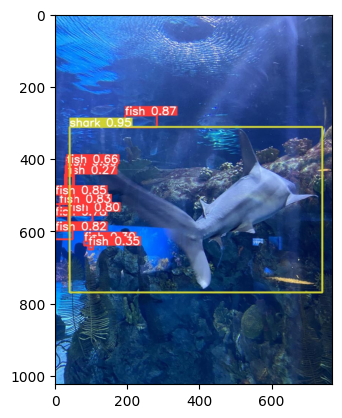

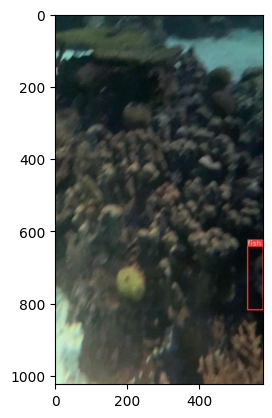

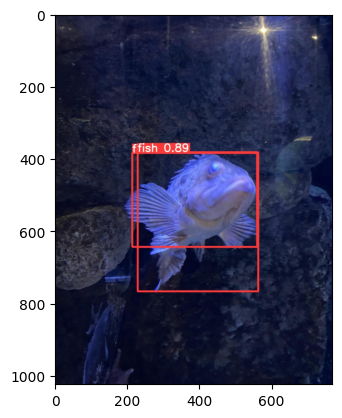

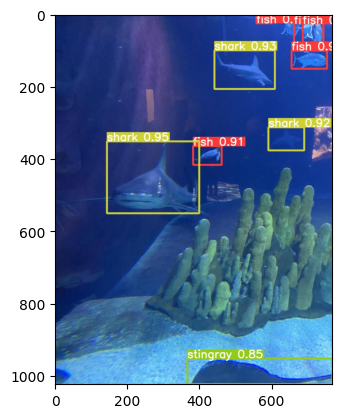

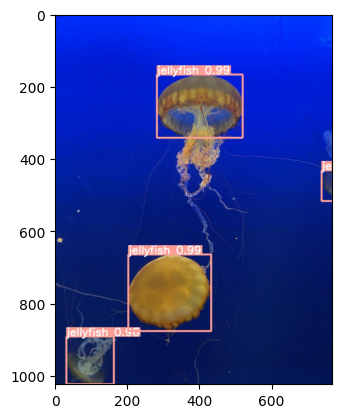

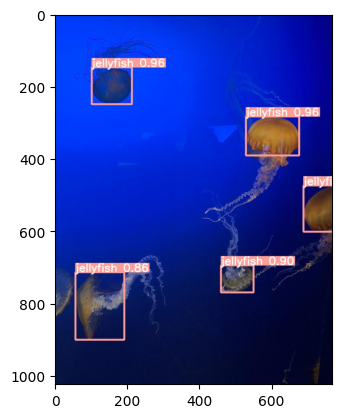

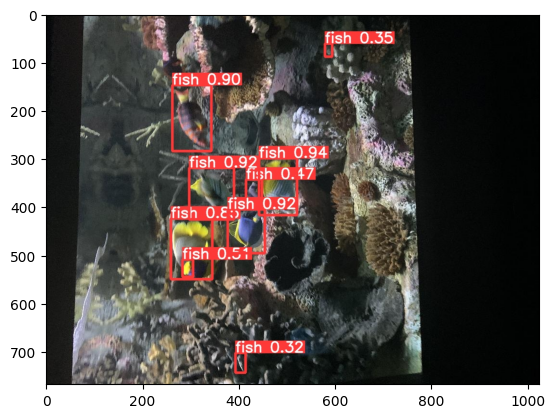

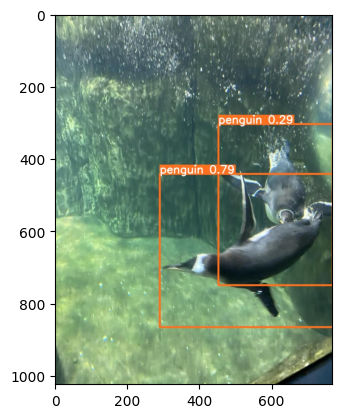

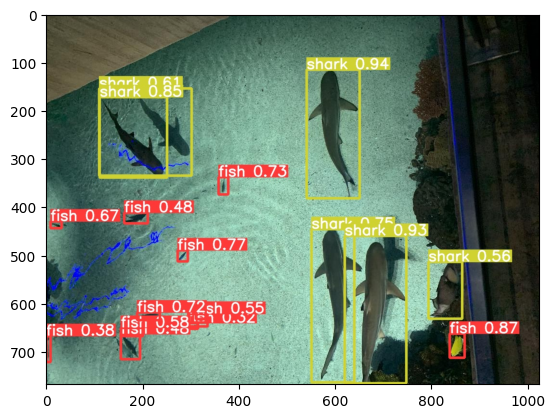

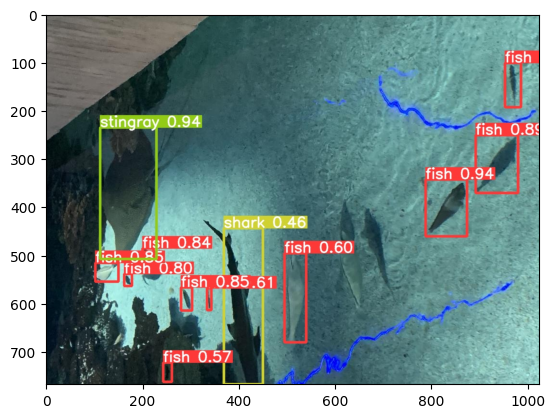

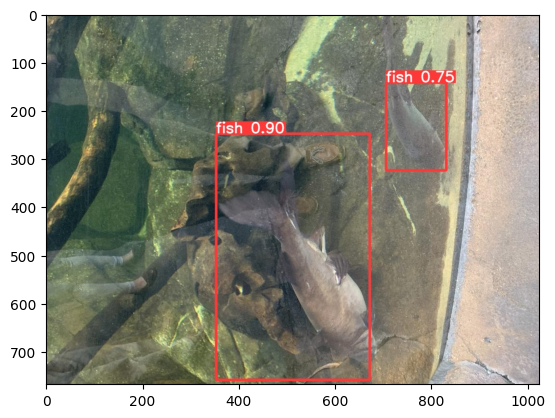

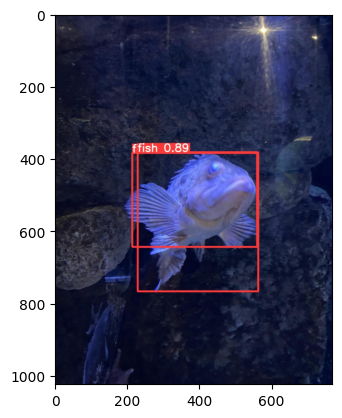

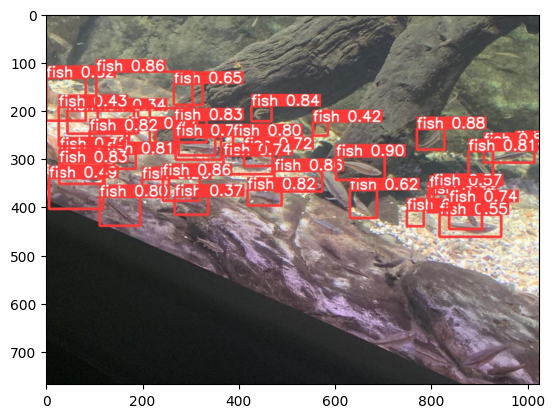

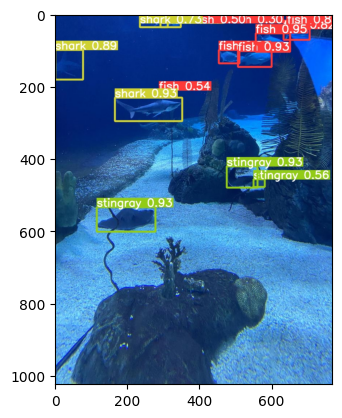

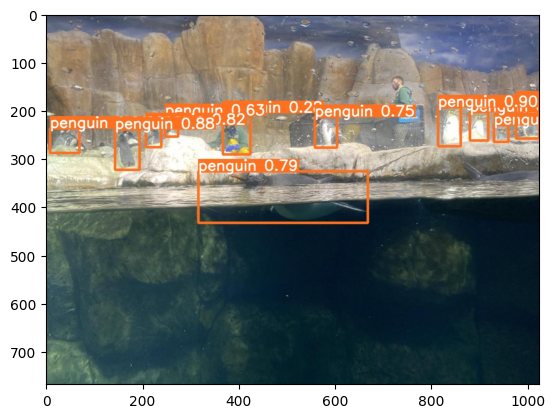

In [30]:

predicitions_aug = glob.glob(os.path.join(CFG.OUTPUT_DIR, 'runs/detect/yolov8n_underwater_augumention62', '*'))

n = 15

for i in range(n):
    idx = np.random.randint(0, len(predicitions_aug))
    image = Image.open(predicitions_aug[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()